<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/NLP_Encoder_Decoder_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let’s look at an important NLP task: *neural machine translation* (NMT), using a pure Encoder-Decoder model.

## An Encoder–Decoder Network for Neural Machine Translation

Let’s take a look at a simple [neural machine translation model](https://arxiv.org/abs/1409.3215) that will translate English sentences to French (see Figure 16-3).

![texto alternativo](https://i.ibb.co/9mx5s5B/machine-learning-model.png)

This two-step model, called an Encoder-Decoder, works much better than trying to translate on the fly with a single sequence-to-sequence RNN, since the last words of a sentence can affect the first words of the translation, so we need to wait until we have "heard" the whole sentence before translating it (see notebook [Introduction to RNNs](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_RNNs.ipynb)).

In short, the English sentences are fed to the encoder, and the decoder outputs the French translations. Note that the French translations are also used as inputs to the decoder, but shifted back by one step. In other words, the decoder is given as input the word that it *should* have output at the previous step (regardless of what it actually output). For the very first word, it is given the start-of-sequence (SOS) token. The decoder is expected to end the sentence with an end-of-sequence (EOS) token.

Note that the English sentences are reversed before they are fed to the encoder. For example, "I drink milk" is reversed to "milk drink I". This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that’s generally the first thing that the decoder needs to translate.

Each word is initially represented by its ID (e.g., 288 for the word "milk"). Next, an `embedding` layer returns the word embedding. These word embeddings are what is actually fed to the encoder and the decoder.



At each step, the decoder outputs a score for each word in the output vocabulary (i.e., French), and then the softmax layer turns these scores into probabilities. For example, at the first step the word "Je" may have a probability of 20%, "Tu" may have a probability of 1%, and so on. The word with the highest probability is output. This is very much like a regular classification task, so we can train the model using the "`sparse_categorical_crossentropy`" loss.


At inference time (after training), we will not have the target sentence to feed to the decoder. Instead, we simply feed the decoder the word that it output at the previous step, as shown in Figure 16-4 (this will require an embedding lookup that is not shown in the diagram).


![texto alternativo](https://i.ibb.co/S3ZCXjp/m-t-2.png)

There are a few more details to handle if we implement this model:

- So far we have assumed that all input sequences (to the encoder and to the decoder) have a constant length. But obviously, sentence lengths vary. Since regular tensors have fixed shapes, they can only contain sentences of the same length. We can use masking to handle this, as we will do later. However, if the sentences have very different lengths, we can’t just crop them (because we want full translations, not cropped translations). Instead, we can group sentences into buckets of similar lengths (e.g., a bucket for the 1- to 6-word sentences, another for the 7- to 12-word sentences, and so on), using padding for the shorter sequences to ensure all sentences in a bucket have the same length (check out the [`tf.data.experimental.bucket_by_sequence_length()`](https://www.tensorflow.org/api_docs/python/tf/data/experimental/bucket_by_sequence_length) function for this). For example, "I drink milk" becomes "`<pad> <pad> <pad>` milk drink I".

- We want to ignore any output past the EOS token, so these tokens should not contribute to the loss (they must be masked out). For example, if the model outputs "Je bois du lait `<eos>` oui", the loss for the last word should be ignored.

- When the output vocabulary is large (which is usually the case here), outputting a probability for each possible word would be terribly slow. If the target vocabulary contains, say, 50,000 French words, then the decoder would output 50,000-dimensional vectors, and then computing the softmax function over such a large vector would be very computationally intensive. To avoid this, one solution is to look only at the logits output by the model for the correct word and for a random sample of incorrect words, then compute an approximation of the loss based only on these logits. This *sampled softmax* technique was [introduced](https://arxiv.org/abs/1412.2007) in 2015. In TensorFlow, we can use the [`tf.nn.sampled_softmax_loss()`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) function for this during training and use the normal softmax function at inference time (sampled softmax cannot be used at inference time because it requires knowing the target).

The [TensorFlow Addons](https://www.tensorflow.org/addons) project includes many sequence-to-sequence tools to let us easily build production-ready Encoder–Decoders as we will show later.

## Building a NMT model with Keras 


We are going to build a neural machine translation using an encoder-decoder network for translating English sentences into Spanish sentences. 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Load dataset

In [ ]:
# download data
!wget --quiet http://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [ ]:
def load_dataset(filename):
    with open(filename, mode="r", encoding="utf-8") as fp:
        return fp.read().split("\n")

In [ ]:
# Path to the data txt file on disk.
data_path = '/content/spa.txt'
dataset_lines = load_dataset(data_path)
print(dataset_lines[0:10])
print(len(dataset_lines))

['Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)', 'Go.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)', 'Go.\tVaya.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)', 'Go.\tVáyase.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)', 'Hi.\tHola.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)', 'Run!\t¡Corre!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)', 'Run!\t¡Corran!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)', 'Run!\t¡Corra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)', 'Run!\t¡Corred!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005615 (Seael)', 'Run.\tCorred.\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #6681472 (arh)']
124548


### Data preprocessing

Our dataset is a Spanish-English translation dataset. It contains 124547 pairs of English to Spanish phrases, one pair per line with a tab separating the language. This dataset needs preprocessing before we can work on it. We will also add start-of-sentence and end-of-sentence words so that the model knows when to start and stop predicting.

In [ ]:
num_samples = 10000  # Number of samples to train on
input_sentences, target_sentences = [], []
# We define the start of sentence and the end of sentence words
SOS, EOS = "\t", "\n" 

for line in dataset_lines[: min(num_samples, len(dataset_lines) - 1)]:
    # Get the input and target sentence and discard metadata
    input_sentence, target_sentence, _ = line.split("\t")
    # Split the sentences list into words lists
    input_sentence_tokenized = nltk.word_tokenize(input_sentence)
    target_sentence_tokenized = nltk.word_tokenize(target_sentence)
    # Add the SOS and EOS words in the target sentence
    target_sentence_tokenized.insert(0,SOS)
    target_sentence_tokenized.insert(len(target_sentence_tokenized), EOS)
    input_sentences.append(input_sentence_tokenized)
    target_sentences.append(target_sentence_tokenized)

print(f'Input sentences: {input_sentences[0:10]}\n')
print(f'Target sentences: {target_sentences[0:10]}')

Input sentences: [['Go', '.'], ['Go', '.'], ['Go', '.'], ['Go', '.'], ['Hi', '.'], ['Run', '!'], ['Run', '!'], ['Run', '!'], ['Run', '!'], ['Run', '.']]

Target sentences: [['\t', 'Ve', '.', '\n'], ['\t', 'Vete', '.', '\n'], ['\t', 'Vaya', '.', '\n'], ['\t', 'Váyase', '.', '\n'], ['\t', 'Hola', '.', '\n'], ['\t', '¡Corre', '!', '\n'], ['\t', '¡Corran', '!', '\n'], ['\t', '¡Corra', '!', '\n'], ['\t', '¡Corred', '!', '\n'], ['\t', 'Corred', '.', '\n']]


We encode every word of all English sentences as an integer. We use Keras’s Tokenizer class. First, we need to fit a tokenizer to the text: it will find all the word used in the sentences and map each of them to a different character ID, from 1 to the number of distinct characters (it does not start at 0, so we can use that value for masking). We also do the same for the Spanish sentences:

In [ ]:
tokenizer_input = keras.preprocessing.text.Tokenizer(lower=True)
tokenizer_input.fit_on_texts(input_sentences)

tokenizer_target = keras.preprocessing.text.Tokenizer(lower=True)
tokenizer_target.fit_on_texts(target_sentences)

We get the vocabulary size of both English and Spanish sentences.

In [ ]:
input_word_id_dict = tokenizer_input.word_index
input_word_id_dict['PAD'] = 0
#print(f'input_word_id_dict: {input_word_id_dict}')
input_id_word_dict = {v:k for k, v in input_word_id_dict.items()}
num_encoder_tokens = len(input_word_id_dict)
print(f'Number of distinct words in English sentences: {num_encoder_tokens}')

target_word_id_dict = tokenizer_target.word_index
target_word_id_dict['PAD'] = 0
#print(f'target_word_id_dict: {target_word_id_dict}')
target_id_word_dict = {v:k for k, v in target_word_id_dict.items()}
num_decoder_tokens = len(target_word_id_dict)
print(f'Number of distinct words in Spanish sentences: {num_decoder_tokens}')

Number of distinct words in English sentences: 2308
Number of distinct words in Spanish sentences: 5003


Let’s encode both the full English and Spanish sentences so each word is represented by its ID.

In [ ]:
input_sentences_encoded = tokenizer_input.texts_to_sequences(input_sentences)
print(input_sentences_encoded[0:10])
target_sentences_encoded = tokenizer_target.texts_to_sequences(target_sentences)
print(target_sentences_encoded[0:10])

[[23, 1], [23, 1], [23, 1], [23, 1], [292, 1], [170, 18], [170, 18], [170, 18], [170, 18], [170, 1]]
[[1, 71, 3, 2], [1, 238, 3, 2], [1, 281, 3, 2], [1, 488, 3, 2], [1, 432, 3, 2], [1, 2270, 10, 2], [1, 2271, 10, 2], [1, 2272, 10, 2], [1, 2273, 10, 2], [1, 2274, 3, 2]]


We only need the start of the sequence tag in the decoder's input and the end of the sequence tag in the decoder's target.

In [ ]:
input_sentences_decoder = [sentence_encoded[:-1] for sentence_encoded in target_sentences_encoded]
print(input_sentences_decoder[0:10])

[[1, 71, 3], [1, 238, 3], [1, 281, 3], [1, 488, 3], [1, 432, 3], [1, 2270, 10], [1, 2271, 10], [1, 2272, 10], [1, 2273, 10], [1, 2274, 3]]


In [ ]:
target_sentences_decoder = [sentence_encoded[1:] for sentence_encoded in target_sentences_encoded]
print(target_sentences_decoder[0:10])

[[71, 3, 2], [238, 3, 2], [281, 3, 2], [488, 3, 2], [432, 3, 2], [2270, 10, 2], [2271, 10, 2], [2272, 10, 2], [2273, 10, 2], [2274, 3, 2]]


We get the maximum number of words in a English sentence. We do the same for Spanish sentences.

In [ ]:
max_encoder_seq_length = max([len(sentence_as_int) for sentence_as_int in input_sentences_encoded])
print(max_encoder_seq_length)
max_decoder_seq_length = max([len(sentence_as_int) for sentence_as_int in input_sentences_decoder])
print(max_decoder_seq_length)

6
10


We are going to vectorize the words using word embedding when defining the model. Lets pad the English sentences encoded:

In [ ]:
padded_input_sentences_encoded = tf.keras.preprocessing.sequence.pad_sequences(
    input_sentences_encoded, padding="post")
print(padded_input_sentences_encoded[0:10])
print(padded_input_sentences_encoded.shape)

[[ 23   1   0   0   0   0]
 [ 23   1   0   0   0   0]
 [ 23   1   0   0   0   0]
 [ 23   1   0   0   0   0]
 [292   1   0   0   0   0]
 [170  18   0   0   0   0]
 [170  18   0   0   0   0]
 [170  18   0   0   0   0]
 [170  18   0   0   0   0]
 [170   1   0   0   0   0]]
(10000, 6)


This matrix will be the input data for the encoder.

In [ ]:
encoder_input_data = padded_input_sentences_encoded

Let's pad the decoder's input and the decoder's target.

In [ ]:
padded_target_sentences_decoder = tf.keras.preprocessing.sequence.pad_sequences(
    target_sentences_decoder, padding="post")
print(padded_target_sentences_decoder[0:10])
print(padded_target_sentences_decoder.shape)

[[  71    3    2    0    0    0    0    0    0    0]
 [ 238    3    2    0    0    0    0    0    0    0]
 [ 281    3    2    0    0    0    0    0    0    0]
 [ 488    3    2    0    0    0    0    0    0    0]
 [ 432    3    2    0    0    0    0    0    0    0]
 [2270   10    2    0    0    0    0    0    0    0]
 [2271   10    2    0    0    0    0    0    0    0]
 [2272   10    2    0    0    0    0    0    0    0]
 [2273   10    2    0    0    0    0    0    0    0]
 [2274    3    2    0    0    0    0    0    0    0]]
(10000, 10)


In [ ]:
decoder_target_data = padded_target_sentences_decoder

In [ ]:
padded_input_sentences_decoder = tf.keras.preprocessing.sequence.pad_sequences(
    input_sentences_decoder, padding="post")
print(padded_input_sentences_decoder[0:10])
print(padded_input_sentences_decoder.shape)

[[   1   71    3    0    0    0    0    0    0    0]
 [   1  238    3    0    0    0    0    0    0    0]
 [   1  281    3    0    0    0    0    0    0    0]
 [   1  488    3    0    0    0    0    0    0    0]
 [   1  432    3    0    0    0    0    0    0    0]
 [   1 2270   10    0    0    0    0    0    0    0]
 [   1 2271   10    0    0    0    0    0    0    0]
 [   1 2272   10    0    0    0    0    0    0    0]
 [   1 2273   10    0    0    0    0    0    0    0]
 [   1 2274    3    0    0    0    0    0    0    0]]
(10000, 10)


In [ ]:
decoder_input_data = padded_input_sentences_decoder

In [ ]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(10000, 6)
(10000, 10)
(10000, 10)


### Build the model

In [ ]:
import tensorflow_addons as tfa
from keras.layers import Input, Embedding, LSTM, Dense, LSTMCell
from keras.models import Model
from keras.utils.vis_utils import plot_model

rnn_units = 256  # Number of recurrent units in the LSTM layer.
dim_embedding = 128

As we discussed, the model is divided into two sub-models: the encoder responsible for outputting a fixed-length encoding of the input English sequence, and the decoder responsible for predicting the output sequence, one word per output time step.

The first step is to define the encoder. The input to the encoder is a sequence of words, each encoded as embedding vectors with a length of `dim_embedding`.

In [ ]:
encoder_inputs = Input(shape=[None], dtype=np.int32)
encoder_embeddings = Embedding(num_encoder_tokens,
                               dim_embedding)(encoder_inputs)

We set `return_state=True` when creating the `LSTM` layer so that we can get its final hidden state and pass it to the decoder. Since we are using an LSTM cell, it actually returns two hidden states (short term and long term).

In [ ]:
encoder = LSTM(rnn_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
# We discard encoder_outputs and only keep the states.
encoder_states = [state_h, state_c]

Next, we define the decoder. The decoder input is defined as a sequence of Spanish words encoded to embedding vectors with a length of `dim_embedding`.

In [ ]:
decoder_inputs = Input(shape=(None,))
decoder_embeddings = Embedding(num_decoder_tokens,
                               dim_embedding)(decoder_inputs)

The LSTM layer is defined to both return sequences and states. The final hidden and cell states are ignored and only the output sequence of hidden states is referenced.

The final hidden and cell state from the encoder is used to initialize the state of the decoder. This means every time that the encoder model encodes an input sequence, the final internal states of the encoder model are used as the starting point for outputting the first word in the output sequence. This also means that the encoder and decoder LSTM layers must have the same number of cells, in this case, `rnn_units`.

A `Dense` output layer is used to predict each word. This Dense is used to produce each word in the output sequence in a one-shot manner, rather than recursively, at least during training. This is because the entire target sequence required for input to the model is known during training.

In [ ]:
sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = LSTMCell(rnn_units)
output_layer = Dense(num_decoder_tokens)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, state_h_dec, state_c_dec = decoder(
    decoder_embeddings, initial_state=encoder_states)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)



The `TrainingSampler` is one of several samplers available in TensorFlow Addons: their role is to tell the decoder at each step what it should pretend the previous output was. During inference, this should be the embedding of the token that was actually output. During training, it should be the embedding of the previous target token: this is why we used the TrainingSampler. 

Finally, the model is defined with inputs for the encoder and the decoder and the output target sequence.

In [ ]:
model = Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=[Y_proba])

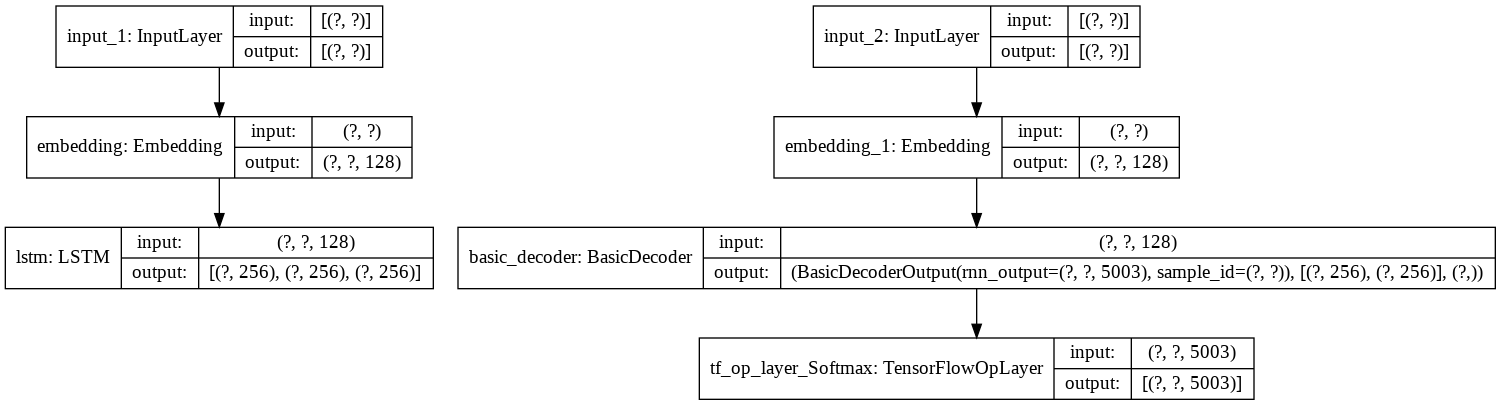

In [ ]:
# plot the model
plot_model(model, to_file='model.png', show_shapes=True)

Note, as it is not noted by the output shape information, the decoder uses the final hidden and cell states of the encoder LSTM as the initial state for the decoder. Also note that the decoder LSTM only passes the sequence of hidden states to the Dense for output, not the final hidden and cell states as suggested by the output shape information.

### Train the model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
batch_size = 32
epochs = 30

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/30
250/250 [==============================] - 8s 31ms/step - loss: 2.6784 - accuracy: 0.6344 - val_loss: 2.4096 - val_accuracy: 0.6685
Epoch 2/30
250/250 [==============================] - 7s 28ms/step - loss: 1.8670 - accuracy: 0.7214 - val_loss: 2.2416 - val_accuracy: 0.6828
Epoch 3/30
250/250 [==============================] - 7s 29ms/step - loss: 1.6781 - accuracy: 0.7402 - val_loss: 2.0932 - val_accuracy: 0.7042
Epoch 4/30
250/250 [==============================] - 7s 29ms/step - loss: 1.5078 - accuracy: 0.7598 - val_loss: 2.0324 - val_accuracy: 0.7142
Epoch 5/30
250/250 [==============================] - 7s 28ms/step - loss: 1.3672 - accuracy: 0.7741 - val_loss: 1.9684 - val_accuracy: 0.7272
Epoch 6/30
250/250 [==============================] - 7s 28ms/step - loss: 1.2392 - accuracy: 0.7863 - val_loss: 1.9195 - val_accuracy: 0.7351
Epoch 7/30
250/250 [==============================] - 7s 28ms/step - loss: 1.1221 - accuracy: 0.7976 - val_loss: 1.9096 - val_accuracy: 0.7383

### Inference

Once the defined model is fit, it can be used to make predictions. Specifically, output a Spanish translation for an English source text.

The model defined for training has learned weights for this operation, but the structure of the model is not designed to be called recursively to generate one word at a time.

Instead, new models are required for the prediction step, specifically a model for encoding English input sequences of words and a model that takes the sequence of Spanish words generated so far and the encoding as input and predicts the next word in the sequence.

Defining the inference models requires reference to elements of the model used for training in the example. Alternatively, one could define a new model with the same shapes and load the weights from the file.

The encoder model is defined as taking the input layer from the encoder in the trained model (´encoder_inputs´) and outputting the hidden and cell state tensors (`encoder_states`).

In [ ]:
#Define an input sequence and process it.
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]

# We discard encoder_outputs and only keep the states.
encoder_model = keras.Model(encoder_inputs, encoder_states)

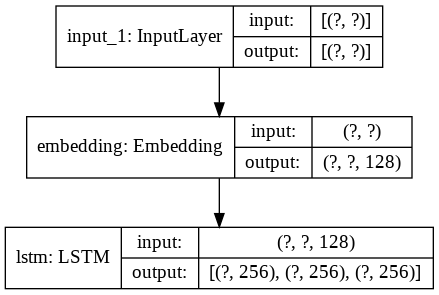

In [ ]:
plot_model(encoder_model, to_file='encoder_model_inf.png', show_shapes=True)

The decoder is more elaborate.

The decoder requires the hidden and cell states from the encoder as the initial state of the newly defined encoder model. Because the decoder is a separate standalone model, these states will be provided as input to the model, and therefore must first be defined as inputs.

In [ ]:
decoder_state_input_h = keras.Input(shape=(rnn_units,), name="input_3")
decoder_state_input_c = keras.Input(shape=(rnn_units,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

They can then be specified for use as the initial state of the decoder LSTM layer.

In [ ]:
decoder_lstm = model.layers[5]# lstm_2
decoder_emb = keras.Input(shape=(max_decoder_seq_length, dim_embedding), name="emb_2")

final_outputs, decoder_states, sequence_lengths = decoder_lstm(
    decoder_emb, initial_state=decoder_states_inputs)

Both the encoder and decoder will be called recursively for each word that is to be generated in the translated sequence.

On the first call, the hidden and cell states from the encoder will be used to initialize the decoder LSTM layer, provided as input to the model directly.

On subsequent recursive calls to the decoder, the last hidden and cell state must be provided to the model. These state values are already within the decoder; nevertheless, we must re-initialize the state on each call given the way that the model was defined to take the final states from the encoder on the first call.

Therefore, the decoder must output the hidden and cell states along with the predicted word on each call, so that these states can be assigned to a variable and used on each subsequent recursive call for a given input sequence of English text to be translated.

In [ ]:
decoder_dense = model.layers[6] #  dense_1
Y_probas = decoder_dense(final_outputs.rnn_output) 

decoder_model = keras.Model(
    [decoder_emb] + decoder_states_inputs, [Y_probas] + decoder_states
)

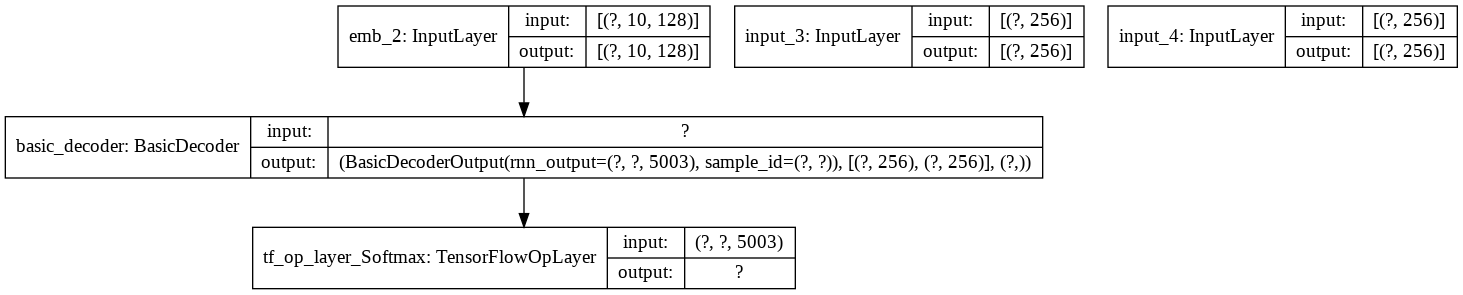

In [ ]:
plot_model(decoder_model, to_file='decoder_model_inf.png', show_shapes=True)

In [ ]:
embedding_decoder = model.layers[3].get_weights()[0]
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first word of target sequence with the SOS word.
    target_seq[0, 0, target_word_id_dict["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        word_emb = tf.matmul(target_seq, embedding_decoder)
        output_tokens, h, c = decoder_model.predict([word_emb] + states_value)

        # Sample a token
        sampled_token_id = np.argmax(output_tokens[0, -1, :])
        sampled_word = target_id_word_dict[sampled_token_id]
        decoded_sentence += sampled_word+' '

        # Exit condition: either hit max length or find stop character.
        if sampled_word == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_id] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
for seq_index in range(1,1000,20):
    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(f'Input sentence: {" ".join(word for word in input_sentences[seq_index])}')
    print(f'Decoded sentence: {decoded_sentence}\n')

Input sentence: Go .
Decoded sentence: váyase . 
 

Input sentence: Stop !
Decoded sentence: ¡para ! 
 

Input sentence: Shoot !
Decoded sentence: ¡dispare ! 

Input sentence: Go now .
Decoded sentence: vayan ya . 

Input sentence: I sang .
Decoded sentence: canté . 
 

Input sentence: Really ?
Decoded sentence: ¿en serio ? 

Input sentence: Be kind .
Decoded sentence: sean gentiles 

Input sentence: Get out .
Decoded sentence: salid . 
 

Input sentence: Hang on !
Decoded sentence: ¡espera un 

Input sentence: Hold it .
Decoded sentence: sostenedla 

Input sentence: I 'm Tom .
Decoded sentence: soy tom . 
 

Input sentence: Push it .
Decoded sentence: empújadla . 

Input sentence: Tom ate .
Decoded sentence: tom comió . 

Input sentence: You run .
Decoded sentence: corre . 
 

Input sentence: Cheer up .
Decoded sentence: venga . 
 

Input sentence: Get lost !
Decoded sentence: ¡vete de aquí 

Input sentence: Have fun .
Decoded sentence: pásala bien 

Input sentence: I agreed .
Decoded

We get some nice results but note that we are decoding samples taken from the training test. In the test set, the results are not so good.

The accuracy can be improved by implementing the beam search algorithm or using bidirectional RNNs or we can also implement an attention mechanism as we will see in the next notebooks.


### Machine translation as a conditional lenguage model

This model can be seen as a conditional language model with regard to a usual language model (see notebook [Character-level language model](https://github.com/victorviro/Deep_learning_python/blob/master/Char_RNN_with_Keras.ipynb)).
![](https://i.ibb.co/XFjRJ1X/lenguage-model-NMT.png)
For a further explanation see this [video](https://youtu.be/Er2ucMxjdHE?list=PLkDaE6sCZn6F6wUI9tvS_Gw1vaFAx6rd6).


# References


- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)

- [Tensorflow tuturial seq2seq NMT](https://www.tensorflow.org/tutorials/text/nmt_with_attention)

- [Sequence to sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

- [Tensorflow Addons tutorial seq2seq](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt)


- [Sequence to Sequence Coursera](https://youtu.be/_i3aqgKVNQI?list=PLkDaE6sCZn6F6wUI9tvS_Gw1vaFAx6rd6)


 - https://github.com/ageron/handson-ml2

